In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from prophet import Prophet

In [10]:
# Preprocessing

df = pd.read_csv('bike_sharing_training.csv')
df.rename(columns={'cnt': 'y', 'dteday': 'ds'}, inplace=True)

df['ds'] = pd.to_datetime(df['ds'], format='%m/%d/%Y')
df[['weathersit_2', 'weathersit_3']] = pd.get_dummies(df['weathersit'], drop_first=True)
df.drop(columns=['instant', 'season', 'yr', 'mnth', 'weekday', 'casual', 'registered', 'weathersit'], 
        inplace=True)  # Remove unneeded variables

df.set_index('ds', inplace=True)
df.index.freq = 'D'

## Exploratory Data Analysis

<Axes: xlabel='ds'>

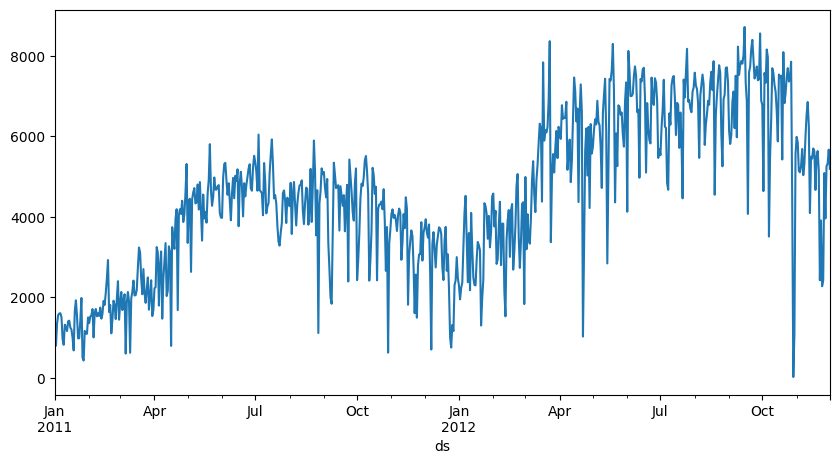

In [11]:
plt.figure(figsize=(10, 5))
df['y'].plot()


In [12]:
# Which factors are correlated with the daily count of shared bikes?

df.corr()[['y']].sort_values('y', ascending=False)

,y
y,1.000000
atemp,0.633885
temp,0.631649
workingday,0.048162
holiday,-0.058080
hum,-0.101409
weathersit_2,-0.166746
windspeed,-0.234871
weathersit_3,-0.234874


In [13]:
#What is the significance level of the variable associations with y?

{'atemp': pearsonr(df['y'], df['atemp'])[1], \
'temp': pearsonr(df['y'], df['temp'])[1], \
'windspeed': pearsonr(df['y'], df['windspeed'])[1], \
'hum': pearsonr(df['y'], df['hum'])[1]}

{'atemp': 4.808082149653423e-80,
 'temp': 2.5097397796383583e-79,
 'windspeed': 3.05974963187083e-10,
 'hum': 0.007207881612862129}

In [14]:
# What is the mean count for each weathersit?
df.pivot_table(index=['weathersit_2', 'weathersit_3'], values='y', aggfunc='mean').reset_index()

,weathersit_2,weathersit_3,y
0,False,False,4881.733925
1,False,True,1871.400000
2,True,False,4065.508696


In [15]:
# What is the significance level of the difference of the means? (For weathersits 2 and 3) 
f_oneway(df[df['weathersit_2'] == True]['y'], 
         df[df['weathersit_3'] == True]['y'])[1]

2.9835810336291315e-07

In [16]:
# What is the mean count for each workingday status?
df.pivot_table(index='workingday', values='y', aggfunc='mean')

,y
workingday,
0,4390.457014
1,4591.387500


In [17]:
# What is the significance level of the difference of the means?
f_oneway(df[df['workingday'] == 1]['y'], 
         df[df['workingday'] == 0]['y'])[1]

0.20279756941426727

In [18]:
# What is the mean count for each workingday status?
df.pivot_table(index='holiday', values='y', aggfunc='mean')

,y
holiday,
0,4547.334802
1,3871.100000


In [19]:
# What is the significance level of the difference of the means?
f_oneway(df[df['holiday'] == 1]['y'], 
         df[df['holiday'] == 0]['y'])[1]

0.12446261388088206

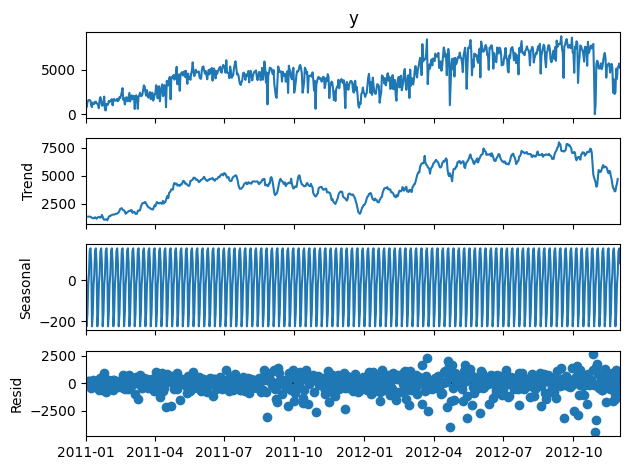

In [20]:
y_decompose = seasonal_decompose(df['y'], model='additive',
                   period=7)

y_decompose.plot()
plt.show()

<Axes: xlabel='ds'>

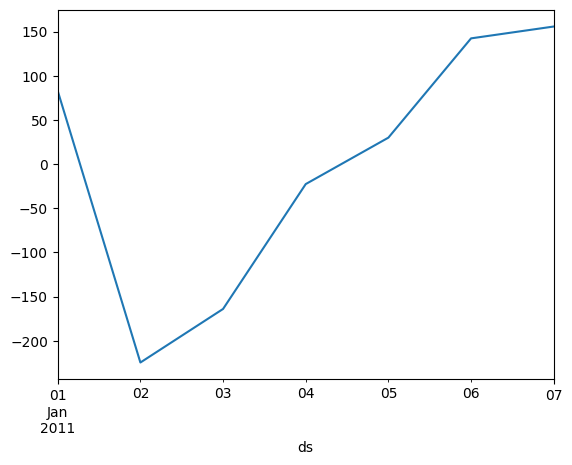

In [21]:
y_decompose.seasonal[:7].plot()

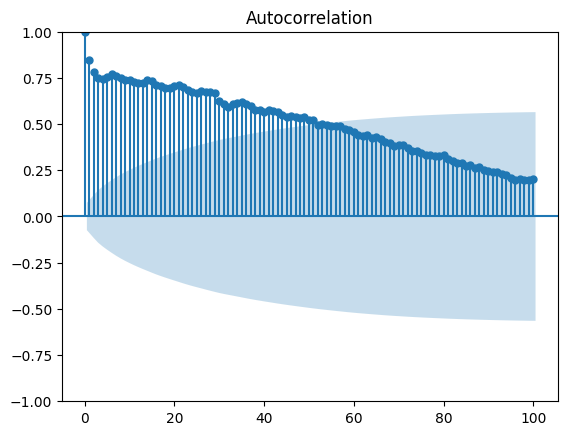

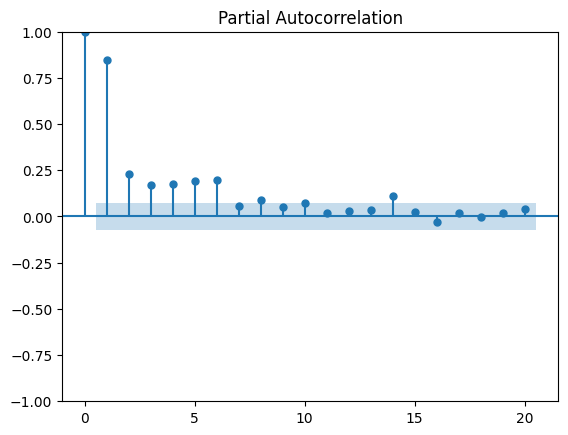

In [23]:
plot_acf(df['y'], lags=100);
plot_pacf(df['y'], lags=20);

In [24]:
def add_holiday(holiday, holiday_date):

    if holiday_date.__class__ == str:
        ds = pd.to_datetime(['2011-'+holiday_date, '2012-'+holiday_date])
    
    elif holiday_date.__class__ == list:
        ds = pd.to_datetime(holiday_date)
    
    elif holiday_date.__class__ == pd.core.indexes.datetimes.DatetimeIndex:
        ds = holiday_date

    holiday_df = pd.DataFrame({'holiday': holiday,
                              'ds': ds,
                              'lower_window': -3,
                              'upper_window': 3})
    
    return holiday_df

In [25]:
gen_holidays = add_holiday('gen_holi', df[df['holiday']==1].index)
xmas = add_holiday('christmas', '12-24')
nye = add_holiday('new_year', '12-31')
easter = add_holiday('easter', ['2011-04-24', '2012-04-08'])

#Combine holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter]).set_index('ds')

holidays.sort_index()#.asfreq('D')

,holiday,lower_window,upper_window
ds,,,
2011-01-17,gen_holi,-3,3
2011-02-21,gen_holi,-3,3
2011-04-15,gen_holi,-3,3
2011-04-24,easter,-3,3
2011-05-30,gen_holi,-3,3
2011-07-04,gen_holi,-3,3
2011-09-05,gen_holi,-3,3
2011-10-10,gen_holi,-3,3
2011-11-11,gen_holi,-3,3


In [26]:
holidays.reset_index(inplace=True)
df.reset_index(inplace=True)

## Prophet Model

In [27]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

model.add_regressor('workingday')
model.add_regressor('atemp')
model.add_regressor('temp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weathersit_2')
model.add_regressor('weathersit_3')

model.fit(df)

23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
from prophet.utilities import regressor_coefficients

In [29]:
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,workingday,multiplicative,0.000000,0.253080,0.253080,0.253080
1,atemp,multiplicative,0.480847,0.266598,0.266598,0.266598
2,temp,multiplicative,0.502732,0.803640,0.803640,0.803640
3,hum,multiplicative,0.625717,-0.408643,-0.408643,-0.408643
4,windspeed,multiplicative,0.190534,-0.655017,-0.655017,-0.655017
5,weathersit_2,multiplicative,0.000000,-0.109053,-0.109053,-0.109053
6,weathersit_3,multiplicative,0.000000,-0.492197,-0.492197,-0.492197


In [30]:
from prophet.diagnostics import cross_validation

# Apply CV to the model

df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')

df_cv

23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8169.283981,7463.196322,8865.484753,6211,2012-06-19
1,2012-06-21,8687.960862,8015.780127,9443.348478,5905,2012-06-19
2,2012-06-22,8315.054497,7679.336738,9020.059760,5823,2012-06-19
3,2012-06-23,7919.551198,7136.698925,8634.802797,7458,2012-06-19
4,2012-06-24,7993.111122,7309.342161,8664.052934,6891,2012-06-19
...,...,...,...,...,...,...
295,2012-11-27,3929.765026,3079.244380,4744.931300,3959,2012-11-01
296,2012-11-28,5642.214863,4785.380805,6450.663143,5260,2012-11-01
297,2012-11-29,5969.623585,5141.534124,6787.455759,5323,2012-11-01
298,2012-11-30,6000.632495,5133.536800,6860.577271,5668,2012-11-01


In [31]:
from prophet.diagnostics import performance_metrics
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.595855e+06,1263.271411,938.986031,0.163430,0.096416,0.157166,0.566667
1,4 days,1.495952e+06,1223.090995,909.006753,0.151204,0.086176,0.147857,0.600000
2,5 days,1.525796e+06,1235.231200,961.355651,0.155735,0.083179,0.151741,0.533333
3,6 days,1.185309e+06,1088.719106,890.602631,0.139537,0.107382,0.140943,0.533333
4,7 days,1.226750e+06,1107.587377,883.498694,0.134523,0.112187,0.140025,0.533333
5,8 days,9.850043e+05,992.473814,771.676786,0.109298,0.108902,0.118709,0.566667
6,9 days,9.690275e+05,984.391963,768.536961,0.107060,0.102567,0.115122,0.533333
7,10 days,1.444415e+06,1201.838161,917.210109,0.132327,0.122231,0.135994,0.466667
8,11 days,1.580920e+06,1257.346267,957.060608,0.143217,0.112013,0.144116,0.500000
9,12 days,2.082660e+06,1443.142376,1124.543243,4.084565,0.124404,0.223108,0.466667


In [32]:
{'rmse': performance_metrics(df_cv)['rmse'].mean(),
 'mape': performance_metrics(df_cv)['mape'].mean()}

{'rmse': 1316.5722279625822, 'mape': 1.0063208090011533}

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


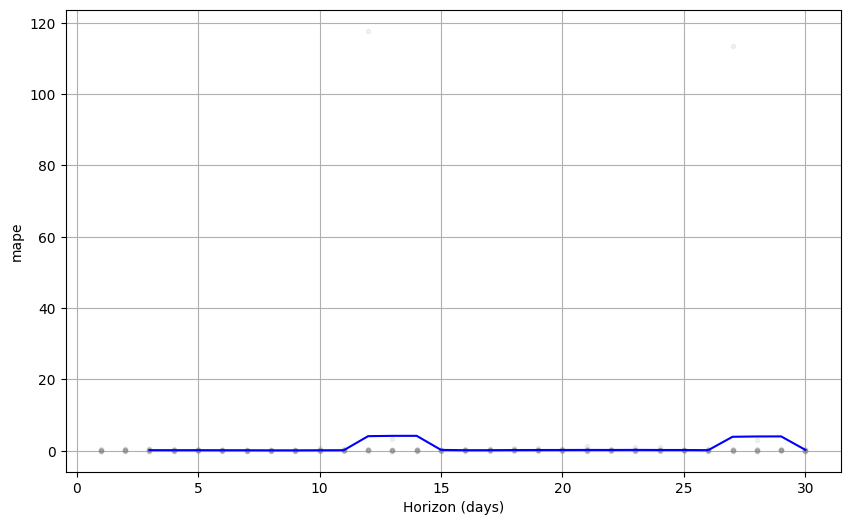

In [33]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='mape');

In [34]:
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']

In [35]:
df_cv['deviation_%'] = (df_cv['yhat'] / df_cv['y']) - 1
df_cv.sort_values('deviation_%', ascending=False).head(10)

# On October 29th, 2012, Hurricane Sandy assaulted Washington D.C.

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_%
251,2012-10-29,2612.898044,1831.187538,3460.080668,22,2012-10-17,2590.898044,117.768093
236,2012-10-29,2516.526397,1688.318967,3291.049329,22,2012-10-02,2494.526397,113.387563
252,2012-10-30,4748.503489,3980.431398,5515.118831,1096,2012-10-17,3652.503489,3.332576
237,2012-10-30,4463.383753,3661.105725,5255.376767,1096,2012-10-02,3367.383753,3.072430
290,2012-11-22,5866.707076,5069.257730,6712.603763,2425,2012-11-01,3441.707076,1.419261
292,2012-11-24,4969.679335,4192.454019,5839.039747,2277,2012-11-01,2692.679335,1.182556
293,2012-11-25,4656.603416,3805.502176,5468.930239,2424,2012-11-01,2232.603416,0.921041
17,2012-07-07,8645.023253,7943.738517,9324.825242,4840,2012-06-19,3805.023253,0.786162
18,2012-07-08,8277.994295,7558.602742,8999.514047,4672,2012-06-19,3605.994295,0.771831
9,2012-06-29,9092.456636,8370.596259,9781.456294,5463,2012-06-19,3629.456636,0.664371


In [39]:
df.loc[df['ds']=='2012-10-29', 'y'] = df.loc[df['ds']=='2012-10-28', 'y']
df.loc[df['ds']=='2012-10-30', 'y'] = df.loc[df['ds']=='2012-10-28', 'y']

In [40]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

model.add_regressor('workingday')
model.add_regressor('atemp')
model.add_regressor('temp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weathersit_2')
model.add_regressor('weathersit_3')

model.fit(df)

23:49:25 - cmdstanpy - INFO - Chain [1] start processing
23:49:25 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
from prophet.diagnostics import cross_validation

# Apply CV to the model

df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')

df_cv

23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8148.935306,7443.176766,8844.811566,6211.0,2012-06-19
1,2012-06-21,8669.660053,7997.792632,9424.695569,5905.0,2012-06-19
2,2012-06-22,8298.353019,7662.931580,9003.029759,5823.0,2012-06-19
3,2012-06-23,7901.237795,7118.750422,8616.168880,7458.0,2012-06-19
4,2012-06-24,7976.991348,7293.541104,8647.621467,6891.0,2012-06-19
...,...,...,...,...,...,...
291,2012-11-27,3963.776524,3138.140968,4755.132104,3959.0,2012-11-01
292,2012-11-28,5528.359631,4696.930161,6314.812745,5260.0,2012-11-01
293,2012-11-29,5857.762460,5053.711785,6651.658571,5323.0,2012-11-01
294,2012-11-30,5913.084077,5071.399746,6747.370598,5668.0,2012-11-01


In [42]:
{'rmse': performance_metrics(df_cv)['rmse'].mean(),
 'mape': performance_metrics(df_cv)['mape'].mean()}

{'rmse': 1271.30397152818, 'mape': 0.15942697085847782}

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


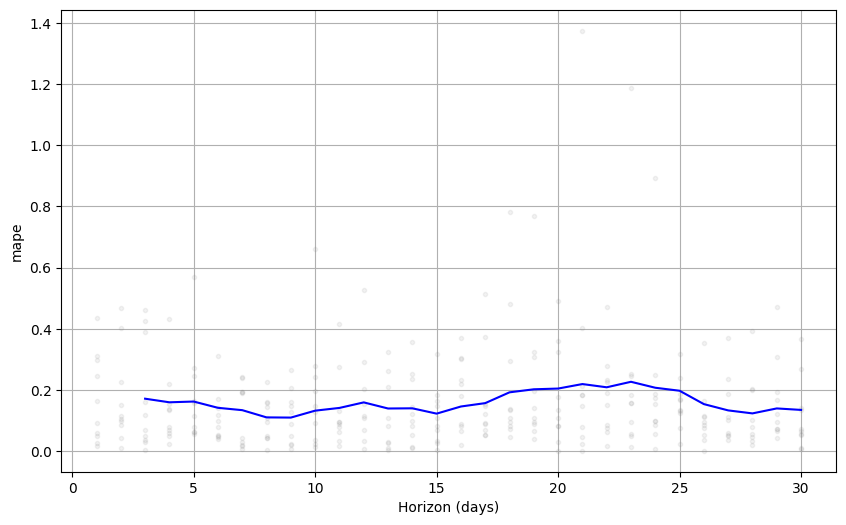

In [43]:
plot_cross_validation_metric(df_cv, metric='mape');

## Feature Engineering

In [50]:
for lag in range(1, 9, 2):
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
    df[f'atemp_lag_{lag}'] = df['atemp'].shift(lag)

df.corr()[['y']]

,y
ds,0.722505
holiday,-0.059451
workingday,0.052493
temp,0.632333
atemp,0.634788
hum,-0.092795
windspeed,-0.229056
y,1.000000
weathersit_2,-0.166765
weathersit_3,-0.222729


In [52]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

model.add_regressor('workingday')
model.add_regressor('atemp')
model.add_regressor('temp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weathersit_2')
model.add_regressor('weathersit_3')
model.add_regressor('temp_lag_1')

model.fit(df.dropna())

00:06:31 - cmdstanpy - INFO - Chain [1] start processing
00:06:31 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
from prophet.diagnostics import cross_validation

# Apply CV to the model

df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')

df_cv

00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8197.723606,7499.703137,8885.970147,6211.0,2012-06-19
1,2012-06-21,8516.564788,7852.063849,9263.321952,5905.0,2012-06-19
2,2012-06-22,8091.683608,7463.229050,8788.634953,5823.0,2012-06-19
3,2012-06-23,7706.725135,6932.817102,8413.933772,7458.0,2012-06-19
4,2012-06-24,7870.241703,7194.284937,8533.528880,6891.0,2012-06-19
...,...,...,...,...,...,...
291,2012-11-27,4060.993901,3247.766194,4840.535812,3959.0,2012-11-01
292,2012-11-28,5732.995584,4915.405857,6508.010062,5260.0,2012-11-01
293,2012-11-29,5970.739294,5178.226459,6752.628936,5323.0,2012-11-01
294,2012-11-30,6122.140519,5293.291989,6942.229405,5668.0,2012-11-01


In [54]:
{'rmse': performance_metrics(df_cv)['rmse'].mean(),
 'mape': performance_metrics(df_cv)['mape'].mean()}

{'rmse': 1240.238910702213, 'mape': 0.1559866880748708}

## Parameter Tuning

In [58]:
from sklearn.model_selection import ParameterGrid

param_grid = {'changepoint_prior_scale': [0.05, 0.5],
              'seasonality_prior_scale': [10, 20],
              'holidays_prior_scale':[10, 20],
              'seasonality_mode': ['additive', 'multiplicative']}

all_params = list(ParameterGrid(param_grid))

In [60]:
tuning_results = []

for params in all_params:
    
    model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = params['seasonality_mode'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                changepoint_prior_scale=params['changepoint_prior_scale'])

    model.add_regressor('workingday')
    model.add_regressor('atemp')
    model.add_regressor('temp')
    model.add_regressor('hum')
    model.add_regressor('windspeed')
    model.add_regressor('weathersit_2')
    model.add_regressor('weathersit_3')
    model.add_regressor('temp_lag_1')

    model.fit(df.dropna())

    df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')


    metrics = {'rmse': performance_metrics(df_cv)['rmse'].mean(),
    'mape': performance_metrics(df_cv)['mape'].mean()}

    tuning_results.append(metrics)

00:20:15 - cmdstanpy - INFO - Chain [1] start processing
00:20:15 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing
00:20:16 - cmdstanpy - INFO - Chain [

In [96]:
outcomes = pd.DataFrame(all_params)
outcomes['rmse'] = [x['rmse'] for x in tuning_results]
outcomes['mape'] = [x['mape'] for x in tuning_results]
best_params = all_params[outcomes.query('rmse == rmse.min()').index.to_list()[0]]